## Deep Learning Approaches for RF-based detection & classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision.models as models

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# import custom functions
from helper_functions import *
from latency_helpers import *
from loading_functions import *

from Torch_Models import *

# from torchsummary import summary

### Load Features

In [2]:
feat_folder = '../Features/'
feat_name = 'PSD'
seg_len = 20
n_per_seg = 1024
interferences = ['WIFI','CLEAN','BLUE','BOTH']
output_name = 'drones'
feat_format = 'IMG'

dataset = DroneDetectTorch(feat_folder, feat_name, seg_len, n_per_seg, feat_format,
                                output_name, interferences)

# dataset = load_dronedetect_data(feat_folder, feat_name, seg_len, n_per_seg, feat_format,
#                                 output_name, interferences)

Directory Name:  ../Features/IMG_PSD_1024_20/


In [3]:
print('dataset size', len(dataset))
print('shape of each item', dataset.__getitem__(12)[0].shape)

dataset size 38978
shape of each item torch.Size([224, 224, 3])


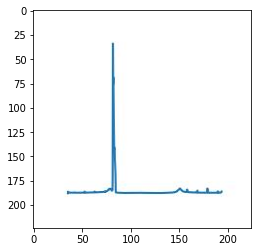

In [4]:
d = dataset.__getitem__(4)[0]
plt.imshow(d)
plt.show()

## VGG16 Features

In [24]:
vgg16 = models.vgg16(pretrained=True)
# summary(vgg16, (3,224,224))

modules=list(vgg16.children())[:-1]
vggmodel=nn.Sequential(*modules)

for p in vggmodel.parameters():
    p.requires_grad = False

In [25]:
# test one input
d = dataset.__getitem__(11)
inarr = d[0]
inarr = torch.moveaxis(inarr, 2, 0)
inarr =inarr.unsqueeze(dim=0)
print(inarr.shape)
# print(inarr.shape)
# postmove = inarr[0]
# print(premove==postmove) # confirm it is the same channel

# WHEN using single channel array format
# inputr = inarr.repeat(1,3,1,1)
# inputr = inputr.to(device)
out = vggmodel(inarr)

# reshape the output
out.flatten()

torch.Size([1, 3, 224, 224])


tensor([0., 0., 0.,  ..., 0., 0., 0.])

## Resnet Features

In [26]:
## Transfer learning from Resnet50 & Apply Logistic Regression (Swinney paper)

# use pretrained resnet feature and just keep up to the last layer
resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-2]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [27]:
# test resnet
# input = torch.randn(1,1,30,300)
d = dataset.__getitem__(0)
inarr = d[0]

inarr = torch.moveaxis(inarr, 2, 0)
inarr = inarr.unsqueeze(dim=0)
print(inarr.shape)
# resnet50(inarr).shape

resnet50(inarr).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 2048, 7, 7])

### Generate Pretrained/Transfer Learning Features

In [28]:
ModelDict = {'vgg':vggmodel, 'resnet': resnet50}

which_model = 'vgg'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ModelDict[which_model] = ModelDict[which_model].to(device) #set model to device

Feats = []
y_num = [] # numerical values for y
for n in tqdm(range(len(dataset))):
    d = dataset.__getitem__(n)
    inarr = d[0]
#     inputr = inarr.repeat(1,3,1,1)  # repeat to have 3 channels of the same info
    inputr = torch.moveaxis(inarr, 2, 0) # move axis to have channels come first
    inputr =inputr.unsqueeze(dim=0)
    inputr = inputr.to(device)
    out = ModelDict[which_model](inputr)
    
    Feats.append(out.cpu().numpy().flatten())
    y_num.append(np.array(d[1]))

Feats = np.array(Feats)
y_num = np.array(y_num)

# flatten the middle dimension
Feats = Feats.reshape(Feats.shape[0], Feats.shape[-1])
# invert labels back to categorical
# vgg_y_cat = dataset.le.inverse_transform(vgg_y.astype(np.int64))
y_cat = np.array([dataset.idx_to_class[i] for i in y_num])

100%|██████████████████████████████████████████████████████████████████████████████████████████| 38978/38978 [02:18<00:00, 280.92it/s]


In [40]:
# Save VGG features
# vgg_save = {'feats': vgg_feats, 'y_cat':vgg_y_cat, 'y':vgg_y}
# file_name = 'transfer_learning_feats/VggFeats_'+str(seg_len)+'_'+str(n_per_seg)+'correct_psd_img'
# np.save(file_name, vgg_save)

### Run Logistic Regression

In [29]:
Xs_feat = Feats # which features to use for logit reg
y_cat = y_cat
print('Shape of Input Features: (n sample x n feats):', Xs_feat.shape)

Shape of Input Features: (n sample x n feats): (38978, 25088)


In [30]:
## KFOLD split

k_fold = 5
cv = KFold(n_splits=k_fold, random_state=1, shuffle=True)


In [ ]:
### The dimension of data is not reasonable (more features than examples)
# Reduce dimension with PCA

# pca = PCA()
# # Define a Standard Scaler to normalize inputs
# scaler = StandardScaler()

# # set the tolerance to a large value to make the example faster
# logistic = LogisticRegression(max_iter=10000)
# pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
# print(pipe)
# # different parameters
# param_grid = {
#     "pca__n_components": [800],
#     "logistic__C": [1, 10],
# }

# best_params_ls = []
# acc_ls = []
# f1_ls = []
# runt_ls = []

# for train_ix, test_ix in tqdm(cv.split(Xs_feat)):
#     clf = GridSearchCV(pipe, param_grid, n_jobs=1)
    
#     clf.fit(Xs_feat[train_ix], y_cat[train_ix])
    
#     print(clf.best_params_)
# #     best_params_ls.append(clf.best_params_)
    
#     # predict on the test data
#     y_pred, runtimes = atomic_benchmark_estimator(clf, Xs_feat[test_ix], output_type= '<U3', 
#                                                   verbose=False)
#     runt_ls.append(np.mean(runtimes))
    
#     acc = accuracy_score(y_cat[test_ix], y_pred)
#     f1 = f1_score(y_cat[test_ix], y_pred, average='weighted')
#     print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
#     acc_ls.append(acc)
#     f1_ls.append(f1)

In [ ]:
# test pca
sc_ls = []
f1_ls = []
tm_ls = []
for train_ix, test_ix in tqdm(cv.split(Xs_feat)):
    scaler = StandardScaler()
    Xtrainscale = scaler.fit_transform(Xs_feat[train_ix])
    
    pca = PCA(n_components=10000)
    pca.fit(Xs_feat[train_ix])
    Xtrainpca = pca.transform(Xtrainscale)
    
    lr = LogisticRegression(max_iter=10000)
    
    lr.fit(Xtrainpca, y_cat[train_ix])
    
    # test
    start = time.time()
    Xtestscale = scaler.transform(Xs_feat[test_ix])
    Xtestpca = pca.transform(Xtestscale)
    y_pred = lr.predict(Xtestpca)
    end = time.time()
    
    t_ave = (end-start)/Xtestpca.shape[0] # batch measure time
    tm_ls.append(t_ave)
    
    sc = accuracy_score(y_cat[test_ix], y_pred)
    sc_ls.append(sc)
    f1 = f1_score(y_cat[test_ix], y_pred, average='weighted')
    f1_ls.append(f1)

out_msg = 'Net+LR: average test acc: {:.2}, F1: {:.2}, Run-time: {:.2}ms'.format(np.mean(sc_ls), np.mean(f1_ls), np.mean(tm_ls)*1e3)
print(out_msg)  


0it [00:00, ?it/s]

In [59]:
f1_score(y_cat[test_ix], y_pred, average='weighted')

0.8396419565588844

In [55]:
tm_ls

[0.0005148707321816803,
 0.0005234912641847237,
 0.0005121750670130158,
 0.0005138173020750074,
 0.0005133497936745498]

In [ ]:
# Directly apply LR - too many features too long

# model parameters
# Cs=list(map(lambda x:pow(10,x),range(-2,2,1)))
# print('Cs:', Cs)

# best_params_ls = []
# acc_ls = []
# f1_ls = []
# runt_ls = []

# parameters = {'C':Cs}

# for train_ix, test_ix in tqdm(cv.split(Xs_feat)):
    
#     # find the optimal hypber parameters
#     lr = LogisticRegression(solver='saga')
# #     clf = GridSearchCV(lr, parameters, n_jobs=1) # gridsearch cv
#     clf = LogisticRegression(C =1.0, max_iter=5000, class_weight = 'balanced',n_jobs=1) # fixed parameter
    
#     scaler = preprocessing.StandardScaler().fit(Xs_feat[train_ix])
#     X_train_scale = scaler.transform(Xs_feat[train_ix])
    
#     clf.fit(X_train_scale, y_cat[train_ix])
    
# #     print(clf.best_params_)
# #     best_params_ls.append(clf.best_params_)
    
#     # predict on the test data
#     X_test_scale = scaler.transform(Xs_feat[test_ix])
#     y_pred, runtimes = atomic_benchmark_estimator(clf, X_test_scale, output_type= '<U3', 
#                                                   verbose=False)
#     runt_ls.append(np.mean(runtimes))
    
#     acc = accuracy_score(y_cat[test_ix], y_pred)
#     f1 = f1_score(y_cat[test_ix], y_pred, average='weighted')
#     print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
#     acc_ls.append(acc)
#     f1_ls.append(f1)
    
# out_msg = 'Net+LR: average test acc: {:.2}, F1: {:.2}, Run-time: {:.2}ms'.format(np.mean(acc_ls), np.mean(f1_ls), np.mean(runt_ls)*1e3)
# print(out_msg)

## Run kNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
## Fixed parameter kNN
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=10, shuffle=True)

# Ns=list(range(2,100,20))
# Ns = [100]
parameters = {'n_neighbors':Ns}
print('list of neighbours:', Ns)

Xs_arr = Vgg_Feats
y_arr = Vgg_y_cat

best_params_ls = []
score_ls = []
f1_ls = []

for train_ix, test_ix in cv.split(Xs_arr):
    # scale data
    scaler = preprocessing.StandardScaler().fit(Xs_arr[train_ix])
    X_train_scale = scaler.transform(Xs_arr[train_ix])
    
    # find the optimal hypber parameters
    clf = KNeighborsClassifier(n_neighbors=5)
#     clf = GridSearchCV(neigh, parameters, n_jobs=1)
    clf.fit(X_train_scale, y_arr[train_ix])
#     print(clf.best_parameters)
    
    # predict on the test data
    X_test_scale = scaler.transform(Xs_arr[test_ix])
#     y_pred = clf.predict(X_test_scale)
    y_pred, runtimes = atomic_benchmark_estimator(clf, X_test_scale, output_type= '<U3', 
                                                  verbose=False)
    acc = accuracy_score(y_arr[test_ix], y_pred)
    f1 = f1_score(y_arr[test_ix], y_pred, average='weighted')
    f1_ls.append(f1)
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    score_ls.append(acc)
    
print('VGG feats+kNN K-fold average test score:', np.mean(score_ls))
print('VGG feats+kNN K-fold average test F1:', np.mean(f1_ls))

list of neighbours: [100]


## Fully Connected Layer

In [100]:
# Model in Torch_Models
# class VGGFC(nn.Module):
#     def __init__(self, num_classes):
#         super(VGGFC,self).__init__()
#         self.num_classes = num_classes
#         self.vggfull = models.vgg16(pretrained=True)
#         modules=list(self.vggfull.children())[:-1] # remove the fully connected layer & adaptive averaging
#         self.vggfeats=nn.Sequential(*modules)
        
#         for param in self.vggfeats.parameters():
#             param.requires_grad_(False)
        
#         self._fc = nn.Linear(25088, num_classes)
#     def forward(self, x):
#         if len(x.shape)==4:
#             x = torch.moveaxis(x,-1, 1)
#         else:
#             x = torch.moveaxis(x, -1, 0)
#         x = self.vggfeats(x)
# #         print(x.shape)
#         x = x.reshape(-1,25088)
#         x = self._fc(x)
        
#         return x

In [5]:
# class ResNetFC(nn.Module):
#     def __init__(self, num_classes):
#         super(ResNetFC,self).__init__()
#         self.num_classes = num_classes
#         self.resnetfull = models.resnet50(pretrained=True)
#         modules=list(self.resnetfull.children())[:-2] # remove the fully connected layer & adaptive averaging
#         self.resnetfeats=nn.Sequential(*modules)
        
#         for param in self.resnetfeats.parameters():
#             param.requires_grad_(False)
        
#         self._fc = nn.Linear(100352, num_classes)
#     def forward(self, x):
#         if len(x.shape)==4:
#             x = torch.moveaxis(x,-1, 1)
#         else:
#             x = torch.moveaxis(x, -1, 0)
#         x = self.resnetfeats(x)
#         x = x.reshape(-1,100352)
#         x = self._fc(x)
        
#         return x

### Kfold CV

In [20]:
from nn_functions import runkfoldcv

In [24]:
# Configuration options
k_folds = 5

batch_size = 128 # 128
num_classes = 7
learning_rate = 0.01
num_epochs = 10 # 0
momentum = 0.95
l2reg = 1e-4

Model = VGGFC(num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
trainedModel, res_acc, res_f1, res_runtime = runkfoldcv(Model, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
    Loss after mini-batch    50: 0.21611
    Loss after mini-batch   100: 0.23081
    Loss after mini-batch   150: 0.22870
    Loss after mini-batch   200: 0.23318
Starting epoch 2
    Loss after mini-batch    50: 0.22025
    Loss after mini-batch   100: 0.21542
    Loss after mini-batch   150: 0.22238
    Loss after mini-batch   200: 0.22282
Starting epoch 3
    Loss after mini-batch    50: 0.21271
    Loss after mini-batch   100: 0.21916
    Loss after mini-batch   150: 0.21282
    Loss after mini-batch   200: 0.21872
Starting epoch 4
    Loss after mini-batch    50: 0.20875
    Loss after mini-batch   100: 0.21702
    Loss after mini-batch   150: 0.21105
    Loss after mini-batch   200: 0.20857
Starting epoch 5
    Loss after mini-batch    50: 0.20477
    Loss after mini-batch   100: 0.20615
    Loss after mini-batch   150: 0.21356
    Loss after mini-batch   200: 0.20486
Starting epoch 6
    L

    Loss after mini-batch   200: 0.15825
Starting epoch 2
    Loss after mini-batch    50: 0.14772
    Loss after mini-batch   100: 0.15783
    Loss after mini-batch   150: 0.15562
    Loss after mini-batch   200: 0.15370
Starting epoch 3
    Loss after mini-batch    50: 0.15013
    Loss after mini-batch   100: 0.15044
    Loss after mini-batch   150: 0.14894
    Loss after mini-batch   200: 0.15829
Starting epoch 4
    Loss after mini-batch    50: 0.14647
    Loss after mini-batch   100: 0.14365
    Loss after mini-batch   150: 0.15970
    Loss after mini-batch   200: 0.15232
Starting epoch 5
    Loss after mini-batch    50: 0.15028
    Loss after mini-batch   100: 0.14706
    Loss after mini-batch   150: 0.14865
    Loss after mini-batch   200: 0.14988
Starting epoch 6
    Loss after mini-batch    50: 0.14911
    Loss after mini-batch   100: 0.14035
    Loss after mini-batch   150: 0.14213
    Loss after mini-batch   200: 0.14785
Starting epoch 7
    Loss after mini-batch    50: 0.14

In [27]:
trainedModel

VGGFC(
  (vggfull): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): 

In [28]:
res_acc, res_f1, res_runtime

(93.77348065207367, 0.9379559245843282, 0.005712414296929129)

## Save model

In [29]:
# Save model
model_type = 'VGGFC'
model_name = model_type+'_'+str(feat_name)+'_'+str(n_per_seg)+'_'+str(seg_len)
model_path = '../saved_models/'
trainedModel = trainedModel.cpu()
torch.save(trainedModel, model_path+model_name)
print('Model saved as:', model_name)

Model saved as: VGGFC_PSD_1024_20


In [16]:
### Test reload
# m2 = torch.load(model_path+model_name)
# in2 = dataset.__getitem__(0)[0]
# out = m2(in2)
# _,pred = torch.max(out,1)